In [6]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

base_dir = 'ZTF_SN_FLUX'
gap_threshold = 50
output_file = 'filtered_explosive_sources.csv'

def split_by_gap(times, fluxes, flux_errs, gap_threshold=50):
    sorted_idx = np.argsort(times)
    times, fluxes, flux_errs = times[sorted_idx], fluxes[sorted_idx], flux_errs[sorted_idx]
    diffs = np.diff(times)
    break_points = np.where(diffs > gap_threshold)[0] + 1

    segments = []
    prev = 0
    for bp in break_points:
        segments.append((times[prev:bp], fluxes[prev:bp], flux_errs[prev:bp]))
        prev = bp
    segments.append((times[prev:], fluxes[prev:], flux_errs[prev:]))
    return segments

def is_physical_segment_valid(times, fluxes, flux_errs):
    if len(fluxes) < 5:
        return False
    peak_idx = np.argmax(fluxes)
    if peak_idx == 0 or peak_idx == len(fluxes) - 1:
        return False
    flux_amp = np.max(fluxes) - np.min(fluxes)
    if flux_amp < 3 * np.mean(flux_errs):
        return False
    if np.std(fluxes) < np.mean(flux_errs):
        return False
    return True

def passes_explosive_segment_test(times, fluxes, flux_errs, gap_threshold=50):
    segments = split_by_gap(times, fluxes, flux_errs, gap_threshold)
    if not segments:
        return False
    best_segment = max(segments, key=lambda seg: np.std(seg[1]) if len(seg[1]) > 1 else 0)
    return is_physical_segment_valid(*best_segment)

valid_sources = []

for sid in tqdm(os.listdir(base_dir)):
    source_path = os.path.join(base_dir, sid)
    if not os.path.isdir(source_path):
        continue

    all_bands_pass = True
    for band in ['g', 'r']:
        file_path = os.path.join(source_path, f'{sid}_{band}.csv')
        if not os.path.exists(file_path):
            all_bands_pass = False
            break
        try:
            df = pd.read_csv(file_path)

            times = df.iloc[:, 0].values
            fluxes = df.iloc[:, 1].values
            flux_errs = df.iloc[:, 2].values
            rbs = df.iloc[:, 3].values
            snr = fluxes / flux_errs
            mask = (snr >= 3) & (rbs >= 0.4)
            times, fluxes, flux_errs = times[mask], fluxes[mask], flux_errs[mask]
            
            if not passes_explosive_segment_test(times, fluxes, flux_errs, gap_threshold):
                all_bands_pass = False
                break
        except:
            all_bands_pass = False
            break

    if all_bands_pass:
        valid_sources.append(sid)

pd.DataFrame({'SourceID': valid_sources}).to_csv(output_file, index=False)
print(f"保存 {len(valid_sources)} 个符合爆发段筛选标准的源到：{output_file}")


100%|██████████| 11631/11631 [00:20<00:00, 567.60it/s]

保存 6220 个符合爆发段筛选标准的源到：filtered_explosive_sources.csv


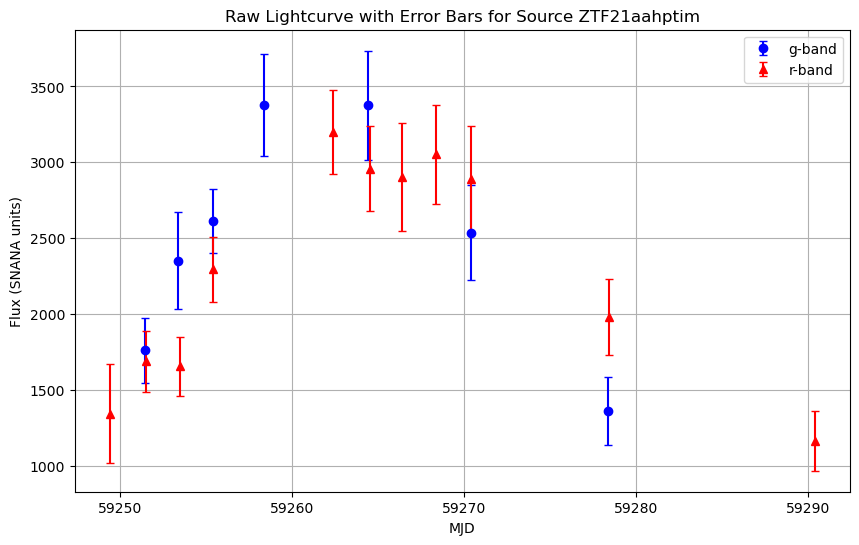

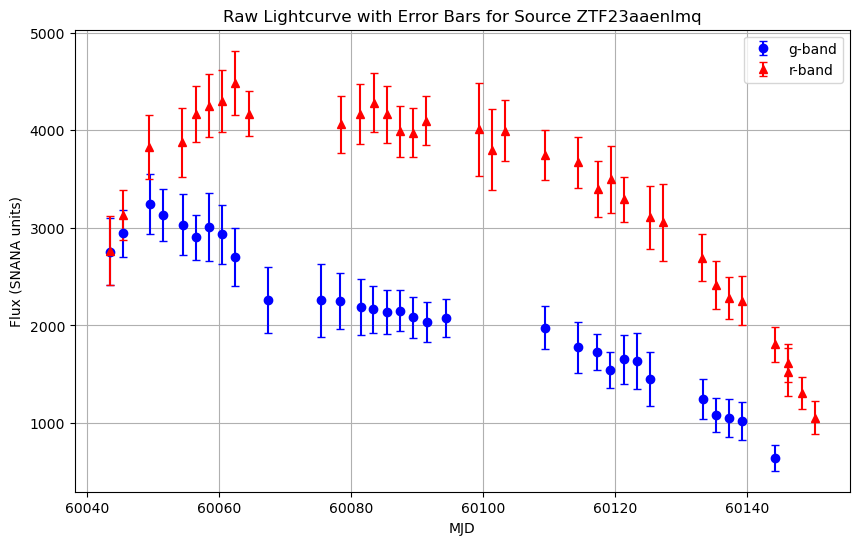

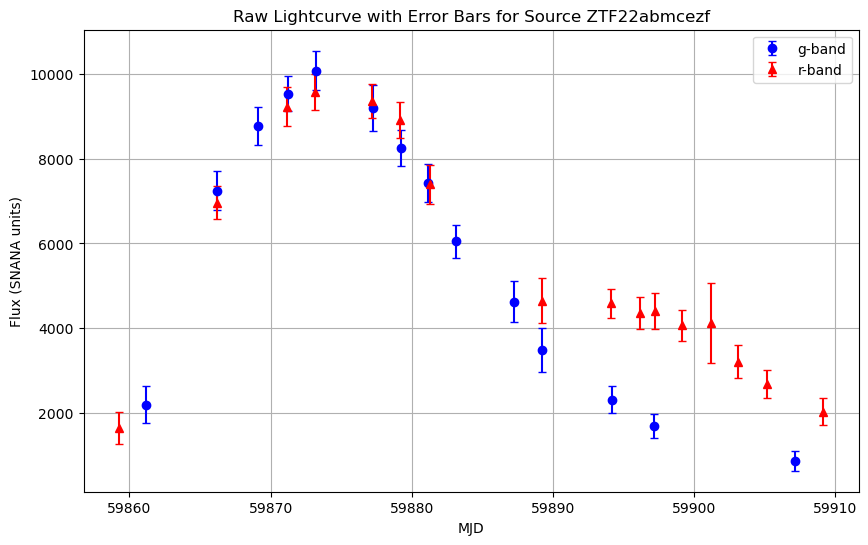

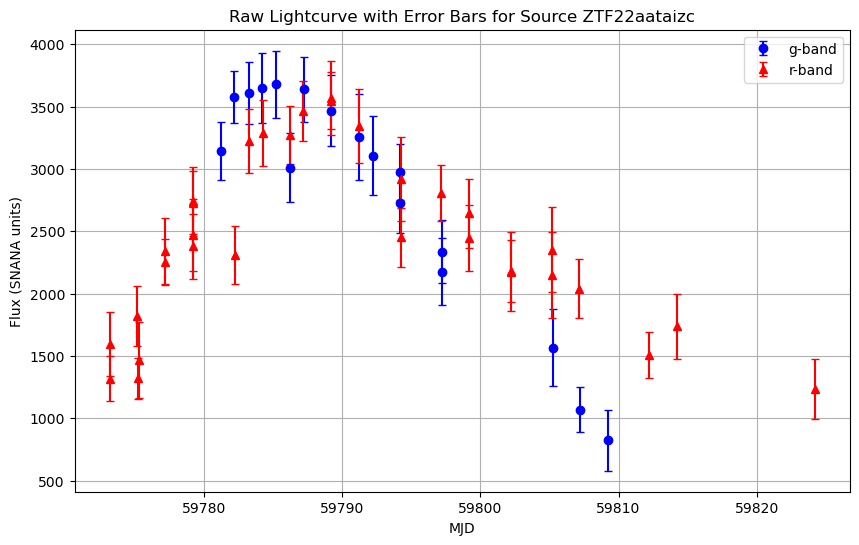

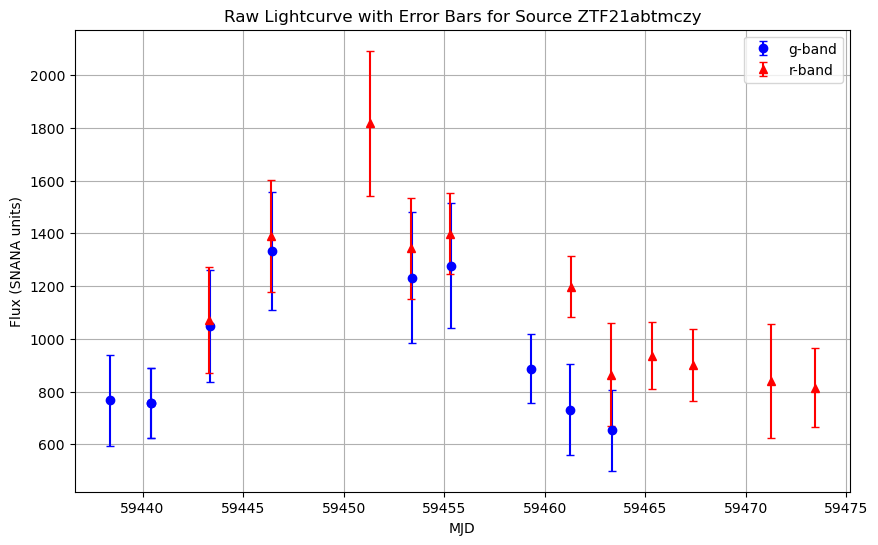

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def plot_flux_lightcurves(source_ids, base_dir='ZTF_SN_FLUX', num_samples=5):
    """
    随机抽取几个源，画出基于flux的g+r光变曲线，并加上误差棒
    """
    sampled_sources = random.sample(source_ids, min(num_samples, len(source_ids)))

    for source_id in sampled_sources:
        g_file = os.path.join(base_dir, source_id, f"{source_id}_g.csv")
        r_file = os.path.join(base_dir, source_id, f"{source_id}_r.csv")

        if not (os.path.exists(g_file) and os.path.exists(r_file)):
            continue

        try:
            # 读g波段
            g_df = pd.read_csv(g_file)
            g_times = g_df.iloc[:, 0].values
            g_fluxes = g_df.iloc[:, 1].values
            g_errors = g_df.iloc[:, 2].values
            rbs = g_df.iloc[:, 3].values
            snr = g_fluxes / g_errors
            mask = (snr >= 3) & (rbs >= 0.4)
            g_times, g_fluxes, g_errors = g_times[mask], g_fluxes[mask], g_errors[mask]

            # 读r波段
            r_df = pd.read_csv(r_file)
            r_times = r_df.iloc[:, 0].values
            r_fluxes = r_df.iloc[:, 1].values
            r_errors = r_df.iloc[:, 2].values
            rbs = r_df.iloc[:, 3].values
            snr = r_fluxes / r_errors
            mask = (snr >= 3) & (rbs >= 0.4)
            r_times, r_fluxes, r_errors = r_times[mask], r_fluxes[mask], r_errors[mask]


        except Exception as e:
            print(f"Error reading {source_id}: {e}")
            continue

        # 绘制
        plt.figure(figsize=(10,6))
        plt.errorbar(g_times, g_fluxes, yerr=g_errors, fmt='o', color='blue', label='g-band', capsize=3)
        plt.errorbar(r_times, r_fluxes, yerr=r_errors, fmt='^', color='red', label='r-band', capsize=3)
        plt.xlabel('MJD')
        plt.ylabel('Flux (SNANA units)')
        plt.title(f'Raw Lightcurve with Error Bars for Source {source_id}')
        plt.legend()
        plt.grid(True)
        plt.show()

# 使用示例
# 抽取ZTF_SN_FLUX目录下所有源id
base_dir = 'ZTF_SN_FLUX'
# source_ids = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

plot_flux_lightcurves(valid_sources, base_dir=base_dir, num_samples=5)


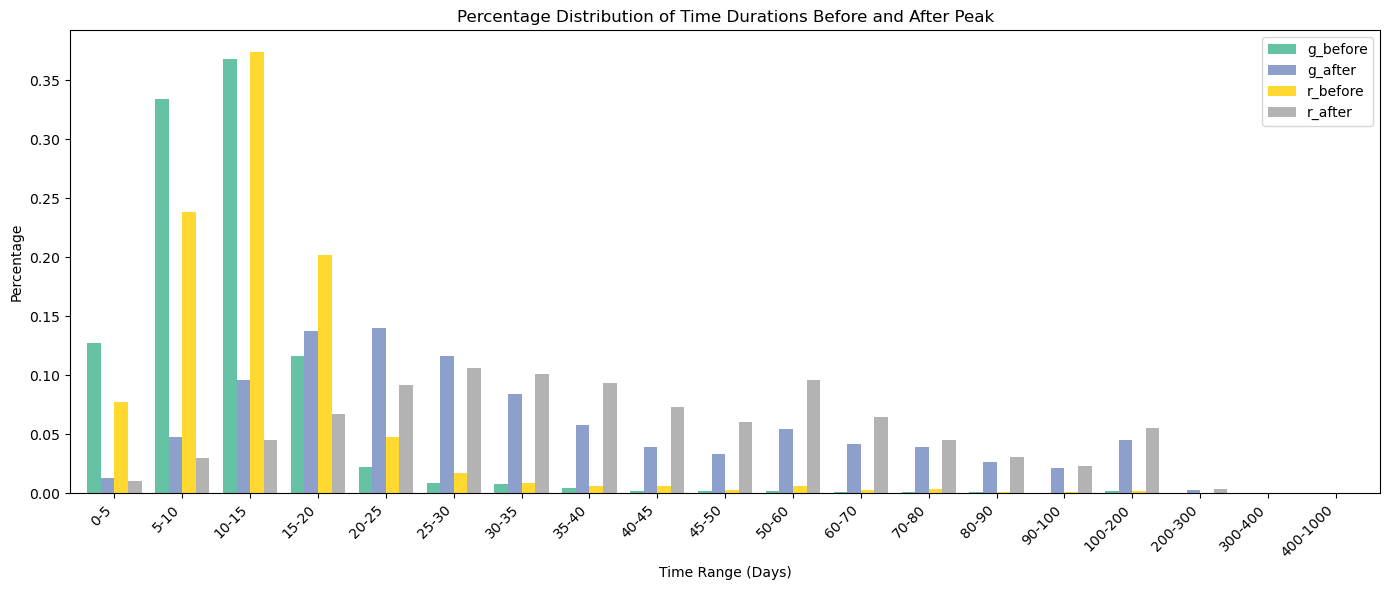

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


def extract_explosive_segment(times, fluxes, flux_errs, gap_threshold=50):
    """
    将给定序列按时间 gap 分段，并返回标准差最大的 segment。

    参数：
        times: array-like, MJD 序列
        fluxes: array-like, flux
        flux_errs: array-like, flux_err
        gap_threshold: float, 相邻点判定为 gap 的时间阈值

    返回：
        times_segment, fluxes_segment, flux_errs_segment
    """
    if len(times) < 2:
        return None, None, None, None, None

    # 按时间排序
    idx_sort = np.argsort(times)
    times = times[idx_sort]
    fluxes = fluxes[idx_sort]
    flux_errs = flux_errs[idx_sort]

    # gap 分段
    diffs = np.diff(times)
    break_points = np.where(diffs > gap_threshold)[0] + 1
    segments = []
    prev = 0
    for bp in break_points:
        segments.append((times[prev:bp], fluxes[prev:bp], flux_errs[prev:bp]))
        prev = bp
    segments.append((times[prev:], fluxes[prev:], flux_errs[prev:]))

    if not segments:
        return None, None, None, None, None

    # 找出 std 最大的段
    best_segment = max(segments, key=lambda seg: np.std(seg[1]) if len(seg[1]) > 1 else 0)
    t_seg, f_seg, e_seg = best_segment
    return t_seg, f_seg, e_seg

# === 配置路径 ===
csv_file = 'filtered_explosive_sources.csv'
base_dir = 'ZTF_SN_FLUX'

# === 读取高完整度数据 ===
df = pd.read_csv(csv_file)

# === 初始化容器 ===
pre_peak_durations = {'g': [], 'r': []}
post_peak_durations = {'g': [], 'r': []}

for _, row in df.iterrows():
    sid = row['SourceID']
    for band in ['g', 'r']:
        file_path = os.path.join(base_dir, sid, f'{sid}_{band}.csv')
        if not os.path.exists(file_path):
            continue
        try:
            data = pd.read_csv(file_path).dropna()
            times = data.iloc[:, 0].astype(float).values
            fluxes = data.iloc[:, 1].astype(float).values
            flux_err = data.iloc[:, 2].astype(float).values
            rbs = data.iloc[:, 3].astype(float).values
            snr = fluxes / flux_err
            mask = (snr >= 3) & (rbs >= 0.4)
            times, fluxes, flux_err = times[mask], fluxes[mask], flux_err[mask]
            times, fluxes, flux_err = extract_explosive_segment(times, fluxes, flux_err)

            peak_idx = np.argmax(fluxes)
            t_peak = times[peak_idx]
            t_min = np.min(times)
            t_max = np.max(times)
            pre_peak_durations[band].append(t_peak - t_min)
            post_peak_durations[band].append(t_max - t_peak)
        except Exception:
            continue

# === 分 bin
bins = list(range(0, 55, 5)) + list(range(60, 110, 10)) + list(range(200, 500, 100))+[1000]
bin_labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

def compute_percentage_histogram(data, bins):
    hist, _ = np.histogram(data, bins=bins)
    percent = hist / np.sum(hist)
    return percent

# === 转为百分比表格
percentage_df = pd.DataFrame(index=bin_labels)
for band in ['g', 'r']:
    pre_pct = compute_percentage_histogram(pre_peak_durations[band], bins)
    post_pct = compute_percentage_histogram(post_peak_durations[band], bins)
    percentage_df[f'{band}_before'] = pre_pct
    percentage_df[f'{band}_after'] = post_pct

# === 可视化
percentage_df.plot(kind='bar', figsize=(14, 6), width=0.8, colormap='Set2')
plt.title("Percentage Distribution of Time Durations Before and After Peak")
plt.ylabel("Percentage")
plt.xlabel("Time Range (Days)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# === 保存为CSV
# percentage_df.to_csv("peak_duration_percentage.csv")
